# Forecasting with an LSTM

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

2023-02-25 09:47:45.186012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

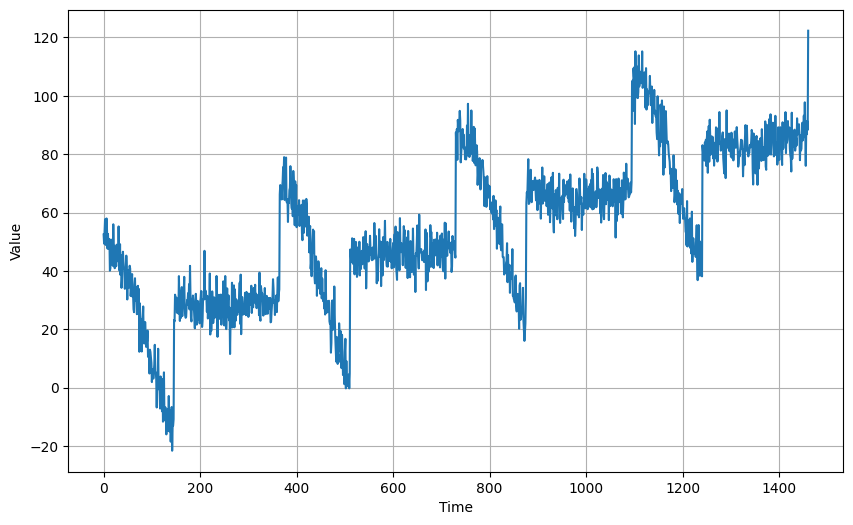

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## LSTM RNN Forecasting

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-25 09:49:46.492983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
33/33 [==============================] - 3s 25ms/step - loss: 9.2361 - mae: 9.7234 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 8.3815 - mae: 8.8664 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 9ms/step - loss: 8.3063 - mae: 8.7932 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 8.1507 - mae: 8.6355 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 10ms/step - loss: 7.9898 - mae: 8.4742 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 9ms/step - loss: 7.8561 - mae: 8.3373 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 9ms/step - loss: 7.7733 - mae: 8.2559 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 10ms/step - loss: 7.6303 - mae: 8.1117 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 9ms/step - loss: 7.7601 - mae: 8.2374 - lr: 2.5119e-0

(1e-08, 0.0001, 0.0, 30.0)

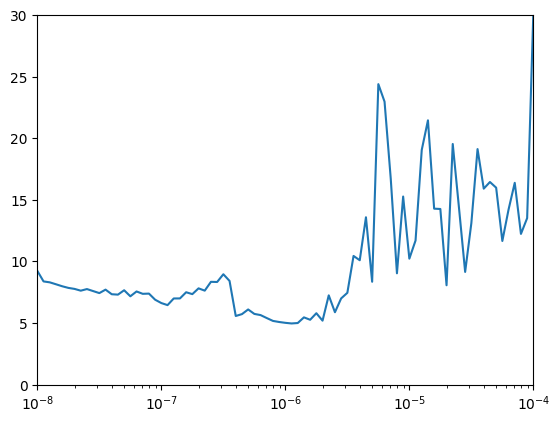

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

emperical_model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
emperical_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
emperical_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
emperical_model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, emperical_model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 4s 36ms/step - loss: 4292.2573 - mae: 4292.7568 - val_loss: 7725.4800 - val_mae: 7725.9810
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 5689.0288 - mae: 5689.5288 - val_loss: 5262.9712 - val_mae: 5263.4712
Epoch 3/500
33/33 [==============================] - 0s 11ms/step - loss: 8584.4717 - mae: 8584.9697 - val_loss: 15422.8447 - val_mae: 15423.3447
Epoch 4/500
33/33 [==============================] - 0s 12ms/step - loss: 5035.0166 - mae: 5035.5181 - val_loss: 1757.8381 - val_mae: 1758.3384
Epoch 5/500
33/33 [==============================] - 0s 14ms/step - loss: 4240.2954 - mae: 4240.7954 - val_loss: 4062.6760 - val_mae: 4063.1755
Epoch 6/500
33/33 [==============================] - 0s 12ms/step - loss: 4707.9160 - mae: 4708.4165 - val_loss: 9914.9590 - val_mae: 9915.4600
Epoch 7/500
33/33 [==============================] - 0s 12ms/step - loss: 5083.6064 - mae: 5084.1074 - val_loss: 5354.1753 - val_mae: 

In [9]:
emperical_model = keras.models.load_model("my_checkpoint.h5")

In [10]:
emperical_rnn_forecast = emperical_model.predict(series[np.newaxis, :, np.newaxis])
emperical_rnn_forecast = emperical_rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 760ms/step


## Mechanized Forecasting with LSTM

In [11]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism


In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

mechanized_model = MechanizedSequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])




## Choose Mechanism and train the model

In [19]:
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.05)


lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)

gaussian_history = mechanized_model.fit(train_set, epochs = 10,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
In Gaussian Mechanism
Create noise when accessing the training data
      1/Unknown - 0s 196ms/step - loss: 80.1559 - mae: 80.6559In Gaussian Mechanism
Create noise when accessing the training data
      2/Unknown - 0s 212ms/step - loss: 76.3653 - mae: 76.8653In Gaussian Mechanism
Create noise when accessing the training data
      3/Unknown - 1s 201ms/step - loss: 69.6861 - mae: 70.1861In Gaussian Mechanism
Create noise when accessing the training data
      4/Unknown - 1s 192ms/step - loss: 57.0951 - mae: 57.5951In Gaussian Mechanism
Create noise when accessing the training data
      5/Unknown - 1s 183ms/step - loss: 58.4717 - mae: 58.9717In Gaussian Mechanism
Create noise when accessing the training data
      6/Unknown - 1s 177ms/step - loss: 58.9090 - mae: 59.4090In Gaussian Mechanism
Create noise when accessing the training data
      7/Unknown - 1s 173ms/step - loss: 59.1626 - mae: 59.6626In Gaussian Mechanism
Create noise when accessing the training data
      8/Un

(1e-08, 0.0001, 0.0, 30.0)

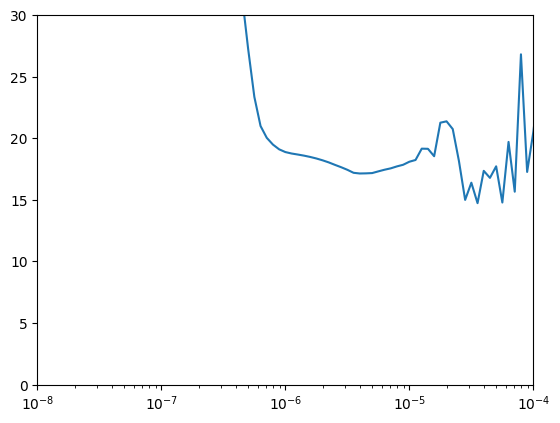

In [20]:
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

## Choose Threshold Mechanism And Fit The Model

In [34]:
class MechanizedSequential(tf.keras.Sequential):


  def __init__(self, *args, **kwargs):
      super(MechanizedSequential, self).__init__(*args, **kwargs)
      self.mechanism = None


      '''
      Parameters for the GnC mechanism 
      '''
      self.mu = 0.0
      self.sigma = 0.03

      '''
      Parameters for the GnC mechanism 
      '''      
      self.beta = None
      self.tau = None
      self.check_for_width = None   


      '''
      Parameters for the Naive Data Splitting mechanism 
      '''
      self.split_size = None


      '''
      Parameters for the Thresholdout mechanism 
      '''
      self.hold_size = None
      self.train_size = None
      self.hold_frac = None
      self.threshold = None
      self.noisy_thresh = None
         
  def choose_mech(self, mech = None):
     self.mechanism = mech
  
  def set_gaussian_para(self, mu, sigma):
     self.set_mechanism_para(mu, sigma)

  def set_mechanism_para(self, mu = 0.0, sigma = None, hold_frac = 0.5, threshold = 0.5, beta = None, tau = None, check_for_width = None):
      self.mu = mu
      self.sigma = sigma
      self.beta = beta
      self.tau = tau
      self.check_for_width = check_for_width
      assert 0.0 < hold_frac <= 1.0, "hold_frac should take a value in (0, 1]."
      self.hold_frac = hold_frac
      self.threshold = threshold
      self.noisy_thresh = self.threshold + np.random.laplace(0, 2 * self.sigma)
     
  def compute_metrics_gaussin(self, x, y, y_pred, sample_weight):
      x_noise = tf.random.normal(
            tf.shape(x),
            mean=self.mu,
            stddev=self.sigma,
            dtype=x.dtype,
            seed=None,
            name=None
            )
      
      noised_x = x_noise + x
  
      y_noise = tf.random.normal(
        tf.shape(y),
        mean=self.mu,
        stddev=self.sigma,
        dtype = y.dtype,
        seed=None,
        name=None
        )
      noised_y = y + y_noise

      self.compiled_metrics.update_state(noised_y, y_pred, sample_weight)

      metrics_results = super(MechanizedSequential, self).compute_metrics(
        noised_x, y, y_pred, sample_weight)
      return metrics_results
  
  def compute_metrics(self, x, y, y_pred, sample_weight):
      if self.mechanism is None:
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        return super(MechanizedSequential, self).compute_metrics(
        x, y, y_pred, sample_weight)
      elif self.mechanism == Mechanism.GAUSSIAN:
         print("In Gaussian Mechanism")
         return self.compute_metrics_gaussin(x, y, y_pred, sample_weight)
      else:
         self.compiled_metrics.update_state(y, y_pred, sample_weight)
         return super(MechanizedSequential, self).compute_metrics(
        x, y, y_pred, sample_weight)
      
  def train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      if self.mechanism is None:
        return super(MechanizedSequential, self).train_step(data)
      elif self.mechanism == Mechanism.GAUSSIAN:
         print("In Gaussian Mechanism")
         return self.gaussian_train_step(data)
      elif self.mechanism == Mechanism.DATASPLIT:
         print("In Naive Data Splitting Mechanism")
         return self.data_split_train_step(data)
      elif self.mechanism == Mechanism.THRESHOLD:
         print("In Threshold out Mechanism")
         return self.thresholdout_train_step(data)
      else:
        return super(MechanizedSequential, self).train_step(data)

      
  
  def gaussian_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      x, y = data
      with tf.GradientTape() as tape:
         print("Create noise when accessing the training data")
         x_noise = tf.random.normal(
               tf.shape(x),
               mean=self.mu,
               stddev=self.sigma,
               dtype=x.dtype,
               seed=None,
               name=None
               )
         noised_x = x_noise + x
         y_pred = self(noised_x, training=True)  # Forward pass
         # Compute the loss value
         # (the loss function is configured in `compile()`)
         noise = tf.random.normal(
               tf.shape(y_pred),
               mean=self.mu,
               stddev=self.sigma,
               dtype = y_pred.dtype,
               seed=None,
               name=None
               )
         
         loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}
  
  '''
  Naive Data Splitting Mechanism:
  Either splitting the data in smaller batch-size and train with more steps,
  or doing the same training steps as the one without any mechanism.
  This one is the version that is the same as the train_step without any mechanism.
  '''
  def data_split_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.

      x, y = data
      with tf.GradientTape() as tape:
         print("In Naive Data Split")
         y_pred = self(x, training=True)  # Forward pass
         loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}
  
  def thresholdout_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      x, y = data
      print()

      hold_size, train_size = int(x.shape[0]  * (self.hold_frac)), int(x.shape[0]  * (1.0 - self.hold_frac))
      x_train, y_train, x_hold, y_hold = x[hold_size:], y[hold_size:], x[:hold_size], y[:hold_size]
      with tf.GradientTape() as tape:

         y_pred_train = self(x_train, training=True)  # Forward pass
         y_pred_hold = self(x_hold, training = True)
         '''
         TODO: Need to consider one of the following model as one shot of query:
          model-1. one step of training, the result of the logistic is a query
          model-2. one step of training, the losse of the trained logistic v.s. the true logistic.
         '''

         '''
         model-1.
         drawback: the query result isn't unform data type, the trained logistic has different size dependents on the databse size.
         '''
         #TODO: subtraction between the tensors of different size
         abs_diff = abs(np.sum(y_pred_train, axis = 0) / train_size - np.sum(y_pred_hold, axis = 0) / hold_size)
         mean_abs_diff = sum(abs_diff) / y.shape[1]
         print(mean_abs_diff)
         if mean_abs_diff >= self.noisy_thresh + np.random.laplace(0, 4 * self.sigma):
            self.noisy_thresh = self.threshold + np.random.laplace(0, 2 * self.sigma)
            y_true, y_pred = y_hold, y_pred_hold + tfp.distributions.Laplace(self.mu, self.sigma).sample(tf.shape(y_pred_hold))
            loss = self.compiled_loss(y_hold, y_pred_hold, regularization_losses=self.losses)
         else:
            y_true, y_pred = y_train, y_pred_train
            loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)

         '''
         model-2:
         drawback: the "loss of  the trained logistic v.s. the true logistic" isn't a direct
          query on the data. 
         advantage: the losses in different steps or different size of database always have the same type.
         '''
         loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)
         loss_hold = self.compiled_loss(y_hold, y_pred_hold, regularization_losses=self.losses)

         if np.abs(loss - loss_hold) >= self.noisy_thresh + np.random.laplace(0, 4 * self.sigma):
            self.noisy_thresh = self.threshold + np.random.laplace(0, 2 * self.sigma)

            loss = loss_hold + tfp.distributions.Laplace(self.mu, self.sigma).sample(tf.shape(loss_hold))
            # min(1.0, max(0.0, loss_hold + np.random.laplace(0, self.sigma)))
            y_true, y_pred = y_hold, y_pred_hold
         else:
            y_true, y_pred = y_train, y_pred_train
            loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)

      
      
      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)
      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y_true, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)


mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)

threshold_history = mechanized_model.fit(train_set, epochs = 2,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/2
In Threshold out Mechanism


ValueError: Exception encountered when calling layer 'mechanized_sequential' (type MechanizedSequential).

Input 0 of layer "lstm" is incompatible with the layer: expected shape=(1, None, 1), found shape=(0, 30, 1)

Call arguments received by layer 'mechanized_sequential' (type MechanizedSequential):
  • inputs=tf.Tensor(shape=(0, 30, 1), dtype=float64)
  • training=True
  • mask=None

(1e-08, 0.0001, 0.0, 30.0)

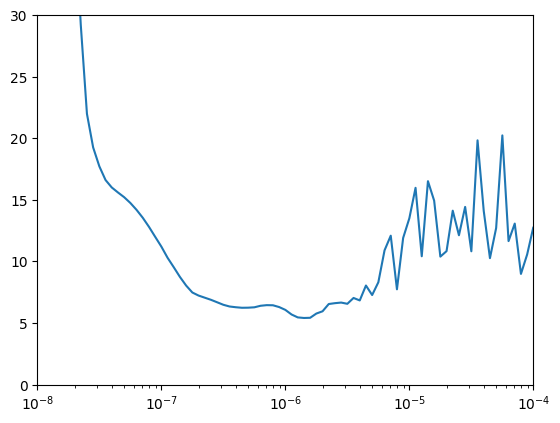

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"], label = "Baseline")
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.semilogx(threshold_history.history["lr"], threshold_history.history["loss"], label = "Thresholdout")
plt.legend()
plt.show()


## Create the Mechanized Model with Check in point

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

mechanized_model = MechanizedSequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])



Epoch 1/500
In Gaussian Mechanism
In Gaussian Mechanism
     32/Unknown - 3s 9ms/step - loss: 2001.1317 - mae: 2001.6335In Gaussian Mechanism


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


33/33 [==============================] - 10s 244ms/step - loss: 2034.0729 - mae: 2034.5747 - val_loss: 1168.2468 - val_mae: 1168.7452
Epoch 2/500
33/33 [==============================] - 0s 12ms/step - loss: 2757.3452 - mae: 2757.8442 - val_loss: 5399.9829 - val_mae: 5400.4829
Epoch 3/500
32/33 [============================>.] - ETA: 0s - loss: 2513.8660 - mae: 2514.3674

INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


33/33 [==============================] - 7s 222ms/step - loss: 2470.8989 - mae: 2471.4009 - val_loss: 287.1375 - val_mae: 287.6370
Epoch 4/500
33/33 [==============================] - 0s 12ms/step - loss: 3757.8179 - mae: 3758.3159 - val_loss: 6078.1504 - val_mae: 6078.6475
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 5551.7402 - mae: 5552.2407 - val_loss: 6251.8604 - val_mae: 6252.3599
Epoch 6/500
33/33 [==============================] - 1s 18ms/step - loss: 4482.9312 - mae: 4483.4316 - val_loss: 1786.6301 - val_mae: 1787.1298
Epoch 7/500
33/33 [==============================] - 0s 13ms/step - loss: 1949.2952 - mae: 1949.7981 - val_loss: 1819.2437 - val_mae: 1819.7458
Epoch 8/500
33/33 [==============================] - 0s 11ms/step - loss: 3335.7896 - mae: 3336.2883 - val_loss: 3817.1072 - val_mae: 3817.6072
Epoch 9/500
33/33 [==============================] - 0s 12ms/step - loss: 3889.4465 - mae: 3889.9443 - val_loss: 940.6046 - val_mae: 941.1070
Epoch 1

## Choose the Gaussian Model and Train the model

In [ ]:
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.05)



optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
reset_states = ResetStatesCallback()
mechanized_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "gaussian_model_checkpoint.h5", save_best_only=True)
mechanized_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "gaussian_model_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)
mechanized_model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, mechanized_model_checkpoint, reset_states])

In [20]:
gaussian_model = keras.models.load_model("gaussian_checkpoint.h5",
                                         custom_objects={'MechanizedSequential':MechanizedSequential})

In [21]:
gaussian_rnn_forecast = gaussian_model.predict(series[np.newaxis, :, np.newaxis])
gaussian_rnn_forecast = gaussian_rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 697ms/step


## Choose the Thresholdout Model and Train the model

In [30]:

class MechanizedSequential(tf.keras.Sequential):


  def __init__(self, *args, **kwargs):
      super(MechanizedSequential, self).__init__(*args, **kwargs)
      self.mechanism = None


      '''
      Parameters for the GnC mechanism 
      '''
      self.mu = 0.0
      self.sigma = 0.03

      '''
      Parameters for the GnC mechanism 
      '''      
      self.beta = None
      self.tau = None
      self.check_for_width = None   


      '''
      Parameters for the Naive Data Splitting mechanism 
      '''
      self.split_size = None


      '''
      Parameters for the Thresholdout mechanism 
      '''
      self.hold_size = None
      self.train_size = None
      self.hold_frac = None
      self.threshold = None
      self.noisy_thresh = None
         
  def choose_mech(self, mech = None):
     self.mechanism = mech
  
  def set_gaussian_para(self, mu, sigma):
     self.set_mechanism_para(mu, sigma)

  def set_mechanism_para(self, mu = 0.0, sigma = None, hold_frac = 0.5, threshold = 0.5, beta = None, tau = None, check_for_width = None):
      self.mu = mu
      self.sigma = sigma
      self.beta = beta
      self.tau = tau
      self.check_for_width = check_for_width
      assert 0.0 < hold_frac <= 1.0, "hold_frac should take a value in (0, 1]."
      self.hold_frac = hold_frac
      self.threshold = threshold
      self.noisy_thresh = self.threshold + np.random.laplace(0, 2 * self.sigma)
     
  def compute_metrics_gaussin(self, x, y, y_pred, sample_weight):
      x_noise = tf.random.normal(
            tf.shape(x),
            mean=self.mu,
            stddev=self.sigma,
            dtype=x.dtype,
            seed=None,
            name=None
            )
      
      noised_x = x_noise + x
  
      y_noise = tf.random.normal(
        tf.shape(y),
        mean=self.mu,
        stddev=self.sigma,
        dtype = y.dtype,
        seed=None,
        name=None
        )
      noised_y = y + y_noise

      self.compiled_metrics.update_state(noised_y, y_pred, sample_weight)

      metrics_results = super(MechanizedSequential, self).compute_metrics(
        noised_x, y, y_pred, sample_weight)
      return metrics_results
  
  def compute_metrics(self, x, y, y_pred, sample_weight):
      if self.mechanism is None:
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        return super(MechanizedSequential, self).compute_metrics(
        x, y, y_pred, sample_weight)
      elif self.mechanism == Mechanism.GAUSSIAN:
         print("In Gaussian Mechanism")
         return self.compute_metrics_gaussin(x, y, y_pred, sample_weight)
      else:
         self.compiled_metrics.update_state(y, y_pred, sample_weight)
         return super(MechanizedSequential, self).compute_metrics(
        x, y, y_pred, sample_weight)
      
  def train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      if self.mechanism is None:
        return super(MechanizedSequential, self).train_step(data)
      elif self.mechanism == Mechanism.GAUSSIAN:
         print("In Gaussian Mechanism")
         return self.gaussian_train_step(data)
      elif self.mechanism == Mechanism.DATASPLIT:
         print("In Naive Data Splitting Mechanism")
         return self.data_split_train_step(data)
      elif self.mechanism == Mechanism.THRESHOLD:
         print("In Threshold out Mechanism")
         return self.thresholdout_train_step(data)
      else:
        return super(MechanizedSequential, self).train_step(data)

      
  
  def gaussian_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      x, y = data
      with tf.GradientTape() as tape:
         print("Create noise when accessing the training data")
         x_noise = tf.random.normal(
               tf.shape(x),
               mean=self.mu,
               stddev=self.sigma,
               dtype=x.dtype,
               seed=None,
               name=None
               )
         noised_x = x_noise + x
         y_pred = self(noised_x, training=True)  # Forward pass
         # Compute the loss value
         # (the loss function is configured in `compile()`)
         noise = tf.random.normal(
               tf.shape(y_pred),
               mean=self.mu,
               stddev=self.sigma,
               dtype = y_pred.dtype,
               seed=None,
               name=None
               )
         
         loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}
  
  '''
  Naive Data Splitting Mechanism:
  Either splitting the data in smaller batch-size and train with more steps,
  or doing the same training steps as the one without any mechanism.
  This one is the version that is the same as the train_step without any mechanism.
  '''
  def data_split_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.

      x, y = data
      with tf.GradientTape() as tape:
         print("In Naive Data Split")
         y_pred = self(x, training=True)  # Forward pass
         loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}
  
  def thresholdout_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      print(data)
      x, y = data
      print(type(data))

      hold_size, train_size = int(x.shape[0]  * (self.hold_frac)), int(x.shape[0]  * (1.0 - self.hold_frac))
      x_train, y_train, x_hold, y_hold = x[hold_size:], y[hold_size:], x[:hold_size], y[:hold_size]
      with tf.GradientTape() as tape:

         y_pred_train = self(x_train, training=True)  # Forward pass
         y_pred_hold = self(x_hold, training = True)
         '''
         TODO: Need to consider one of the following model as one shot of query:
          model-1. one step of training, the result of the logistic is a query
          model-2. one step of training, the losse of the trained logistic v.s. the true logistic.
         '''

         '''
         model-1.
         drawback: the query result isn't unform data type, the trained logistic has different size dependents on the databse size.
         '''
         #TODO: subtraction between the tensors of different size
         abs_diff = abs(np.sum(y_pred_train, axis = 0) / train_size - np.sum(y_pred_hold, axis = 0) / hold_size)
         mean_abs_diff = sum(abs_diff) / y.shape[1]
         print(mean_abs_diff)
         if mean_abs_diff >= self.noisy_thresh + np.random.laplace(0, 4 * self.sigma):
            self.noisy_thresh = self.threshold + np.random.laplace(0, 2 * self.sigma)
            y_true, y_pred = y_hold, y_pred_hold + tfp.distributions.Laplace(self.mu, self.sigma).sample(tf.shape(y_pred_hold))
            loss = self.compiled_loss(y_hold, y_pred_hold, regularization_losses=self.losses)
         else:
            y_true, y_pred = y_train, y_pred_train
            loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)

         '''
         model-2:
         drawback: the "loss of  the trained logistic v.s. the true logistic" isn't a direct
          query on the data. 
         advantage: the losses in different steps or different size of database always have the same type.
         '''
         loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)
         loss_hold = self.compiled_loss(y_hold, y_pred_hold, regularization_losses=self.losses)

         if np.abs(loss - loss_hold) >= self.noisy_thresh + np.random.laplace(0, 4 * self.sigma):
            self.noisy_thresh = self.threshold + np.random.laplace(0, 2 * self.sigma)

            loss = loss_hold + tfp.distributions.Laplace(self.mu, self.sigma).sample(tf.shape(loss_hold))
            # min(1.0, max(0.0, loss_hold + np.random.laplace(0, self.sigma)))
            y_true, y_pred = y_hold, y_pred_hold
         else:
            y_true, y_pred = y_train, y_pred_train
            loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)

      
      
      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)
      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y_true, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}

In [33]:
print(train_set)
mechanized_model = MechanizedSequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
reset_states = ResetStatesCallback()
mechanized_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "gaussian_model_checkpoint.h5", save_best_only=True)
mechanized_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "gaussian_model_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)
mechanized_model.fit(train_set, epochs = 2,
          validation_data=valid_set,
          callbacks=[early_stopping, mechanized_model_checkpoint, reset_states])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>


Epoch 1/2
In Threshold out Mechanism
(<tf.Tensor: shape=(1, 30, 1), dtype=float64, numpy=
array([[[52.48357077],
        [49.35275206],
        [53.31473872],
        [57.71182193],
        [48.93444534],
        [48.93124221],
        [57.98289687],
        [53.89712254],
        [47.67392616],
        [52.68370684],
        [47.59171581],
        [47.50637547],
        [50.95941456],
        [40.08618007],
        [40.91941291],
        [46.6124749 ],
        [44.2282075 ],
        [50.7206442 ],
        [44.45498265],
        [41.76799162],
        [55.98093655],
        [47.33583647],
        [48.60329748],
        [40.93184102],
        [45.11265791],
        [48.15731844],
        [41.60509948],
        [48.98523395],
        [43.83963141],
        [45.10993464]]])>, <tf.Tensor: shape=(1, 30, 1), dtype=float64, numpy=
array([[[49.35275206],
        [53.31473872],
        [57.71182193],
        [48.93444534],
        [48.93124221],
        [57.98289687],
        [53.89712254],
   

ValueError: Exception encountered when calling layer 'mechanized_sequential_1' (type MechanizedSequential).

Input 0 of layer "lstm_2" is incompatible with the layer: expected shape=(1, None, 1), found shape=(0, 30, 1)

Call arguments received by layer 'mechanized_sequential_1' (type MechanizedSequential):
  • inputs=tf.Tensor(shape=(0, 30, 1), dtype=float64)
  • training=True
  • mask=None

In [ ]:
threshold_model = keras.models.load_model("gaussian_checkpoint.h5",
                                         custom_objects={'MechanizedSequential':MechanizedSequential})

In [ ]:
threshold_rnn_forecast = threshold_model.predict(series[np.newaxis, :, np.newaxis])
threshold_rnn_forecast = threshold_rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 697ms/step


## Plot the comparison results

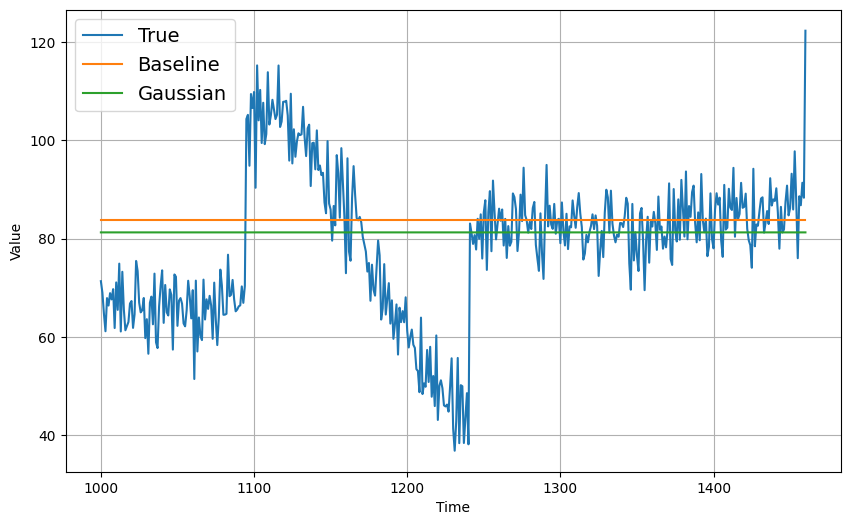

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, emperical_rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")
plot_series(time_valid, threshold_rnn_forecast, label = "Thresholdout")


In [24]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

11.885803

In [25]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()

11.526443